In [1]:
# Read in existing demo

import pickle

demo = pickle.load(open('/home/anton/Documents/Yale/HCP/demographics.pkl', 'rb'))

print('Done')

Done


In [2]:
# List fields

desc = sorted(list(demo.keys()))

fields = desc

types = ['continuous', 'continuous', 'continuous', 'continuous',
         'categorical', 'continuous', 'continuous', 'continuous',
         'categorical', 'categorical', 'continuous', 'continuous',
         'continuous', 'continuous'
        ]

In [3]:
# Get subs with all values

keepSubs = []

for sub in demo['Age_in_Yrs']:
    exclude = False
    for field in list(demo.keys()):
        if sub not in demo[field]:
            exclude = True
    if not exclude:
        keepSubs.append(sub)

print(len(keepSubs))

1067


In [4]:
# Get FC

import numpy as np

fcsPkl = pickle.load(open('/home/anton/Documents/Yale/HCP/fcs_ya.pkl', 'rb'))
fcs = []

for sub in keepSubs:
    sub = str(sub)
    if sub in fcsPkl:
        fcs.append(fcsPkl[sub])

x = np.stack(fcs)

print(len(x))

456


In [5]:
for i in range(len(fields)):
    print(i, fields[i])

0 Age_in_Yrs
1 BMI
2 BPDiastolic
3 BPSystolic
4 Gender
5 Height
6 Hematocrit_1
7 PSQI_Score
8 Race
9 SSAGA_Mj_Use
10 Strength_Unadj
11 Total_Any_Tobacco_7days
12 Total_Drinks_7days
13 Weight


In [18]:
demos = [[] for field in fields]

for sub in keepSubs:
    if str(sub) in fcsPkl:
        for i in range(len(fields)):
            if fields[i] == 'Gender':
                val = int(demo[fields[i]][sub] == 'M')
            elif fields[i] == 'Race':
                val = int(demo[fields[i]][sub] == 'White')
            else:
                val = demo[fields[i]][sub]
            demos[i].append(val)

print('Done')

Done


In [24]:
# Get real subjects

count = 0
real_grp1 = []
real_grp2 = []

for sub in keepSubs:
    if str(sub) in fcsPkl:
        a = demos[0][count]
        b = demos[1][count]
        s = demos[4][count]
        if b < 23:
            real_grp1.append(x[count])
        elif b > 28:
            real_grp2.append(x[count])
        count += 1

real_grp1 = np.stack(real_grp1)
real_grp2 = np.stack(real_grp2)

print(len(real_grp1))
print(len(real_grp2))

179
57


In [13]:
import sys

sys.path.append('/home/anton/Documents/Tulane/Research/demo-vae/pip/src/')

from demovae import DemoVAE

field = 'BMI'

vae = DemoVAE(pperiod=50, use_cuda=True, nepochs=5000, latent_dim=100, weight_decay=0, lr=5e-5, loss_rec_mult=1e3,
              loss_pred_mult=0.01, loss_C_mult=1e4)
vae.load(f'/home/anton/Documents/Yale/HCP/VAE_Models/456_subs/{field}.pkl')

print('Done')

Done


In [14]:
import pickle

dct = pickle.load(open(f'/home/anton/Documents/Yale/HCP/VAE_Models/456_subs/demos_{field}.pkl', 'rb'))

print(list(dct.keys()))
print('Done')

['demos', 'types']
Done


In [15]:
print(dct['demos'][0][:10])
print(dct['demos'][1][:10])
print(dct['demos'][2][:10])
print(dct['demos'][3][:10])
print(dct['demos'][4][:10])

[27 35 29 35 26 30 25 32 26 31]
[0 0 1 0 0 1 0 0 0 0]
[138. 205. 146. 119. 156. 170. 116. 157. 159.  97.]
[65. 69. 68. 64. 64. 68. 64. 66. 68. 64.]
[22.96 30.27 22.2  20.42 26.77 25.85 19.91 25.34 24.17 16.65]


In [25]:
import numpy as np

yhat = []
yhat2 = []

for i in range(20):
    synth = vae.transform(len(dct['demos'][0]), dct['demos'], dct['types'])
    
    for i,fc in enumerate(synth):
        a = dct['demos'][0][i]
        s = dct['demos'][1][i]
        b = dct['demos'][4][i]
        if b < 23:
            yhat.append(fc)
        elif b > 28:
            yhat2.append(fc)

yhat = np.stack(yhat)
yhat2 = np.stack(yhat2)

print(yhat.shape)
print(yhat2.shape)

(3580, 34716)
(1140, 34716)


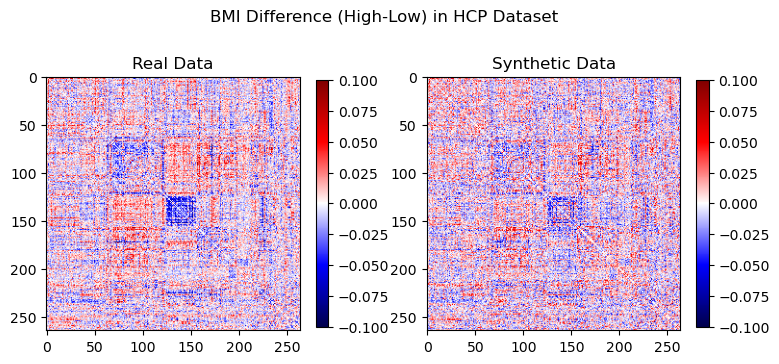

In [26]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

divis = [0,30,35,49,62,120,125,156,181,199,212,221,232,236,264]
labels = ['SMTH','SMTM','CNG','AUD','DMN','MEM','VIS','FRNT','SAL','SUB','VTRL','DRSL','CBL','UNK']

def getlabel(i):
    for j in range(len(divis)):
        if i >= divis[j] and i < divis[j+1]:
            return labels[j]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

real_diff = np.mean(real_grp2, axis=0)-np.mean(real_grp1, axis=0)
real_diff = vec2mat(real_diff)

synth_diff = np.mean(yhat2, axis=0)-np.mean(yhat, axis=0)
synth_diff = vec2mat(synth_diff)

norm = TwoSlopeNorm(vmax=0.1, vmin=-0.1, vcenter=0)

fig, ax = plt.subplots(1,2,figsize=(9,4))

pos = ax[0].imshow(real_diff, cmap='seismic', norm=norm)
fig.colorbar(pos, ax=ax[0], shrink=0.8)

pos = ax[1].imshow(synth_diff, cmap='seismic', norm=norm)
fig.colorbar(pos, ax=ax[1], shrink=0.8)

ax[0].set_title('Real Data')
ax[1].set_title('Synthetic Data')

fig.suptitle('BMI Difference (High-Low) in HCP Dataset')
fig.show()
fig.savefig('/home/anton/Documents/Yale/HCP/Figures/RealSynthBMI2.pdf')